In [1]:
%matplotlib inline
%load_ext ipython_unittest
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers

Using TensorFlow backend.


# Reading data

In [2]:
data = pd.read_csv('../data/market_data.csv').drop(columns=['Unnamed: 0', 'Time'])
num_of_ts = data.shape[1]
data_numpy = data.values.T
np.random.shuffle(data_numpy)

# Splitting into train test and normalization

In [3]:
n_steps_for_train = 60
n_samples = num_of_ts/2
normalisation_constant = 2000 # ~ to make values between 0 and 1
data_numpy *= normalisation_constant
train = data_numpy[:num_of_ts/2, :n_steps_for_train]
x_train = train.reshape(n_samples, n_steps_for_train, 1)
y_train = data_numpy[:num_of_ts/2, n_steps_for_train:]

test = data_numpy[num_of_ts/2:, :n_steps_for_train]
x_test = test.reshape(n_samples, n_steps_for_train, 1)
y_test = data_numpy[num_of_ts/2:, n_steps_for_train:]


# Functions

In [10]:
def max_diff(arr):
    
    """returns max difference in list, such that
    mininmum appears before maximum"""
    
    max_diff = arr[1] - arr[0]
    min_element = arr[0]
    for val in arr:
        if val - min_element > max_diff:
            min_element_spread = min_element
            max_element_spread = val
            max_diff = val - min_element         
        if val < min_element:
            min_element = val
            
    return max_diff, min_element_spread, max_element_spread

def visualize_training_loss(history):
    """Plot loss, during the training on Train and Validation part"""
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'], )
    plt.ylim(.065, .1)
    plt.title('model Mean Absolute Error')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show();
    return None


def estimate_n(data, y_pred, n):
    """ Calculate profit for ginve n.
    """
    trade = np.zeros((data.shape[0], 2), dtype=float)
    for i in range(data.shape[0]):
        std = np.std(y_pred[i, :])
        _, min_element_spread, max_element_spread = max_diff(y_pred[i, :])
        min_achieved = False
        for val in y_pred[i, :]:
            if val < min_element_spread + n * std:
                trade[i, 0] = val
                min_achieved = True
            if min_achieved and val > max_element_spread - n * std:
                trade[i, 1] = val
                break
    cost_function_n = np.sum(trade[:, 1] - trade[:, 0])

    return cost_function_n
    

def trainig_for_best_n(data, y_pred, n_range=np.linspace(0, 1, 20)):
    """Calculate profit for each n in the range"""
    
    cost_function = []
    for n in n_range:
        cost_function_n = estimate_n(data, y_pred, n)
        cost_function.append(cost_function_n)
        print 'We have earned {:.3f} with gap parameter = {:.2f}'.format(cost_function_n, n)
    
    return cost_function

# Defining model

Based on Convolutional network with fully connected linear layer

In [6]:
def cnn_network_training(x_train, y_train, n_steps_for_train, n_epochs=30, batch_size=16):
    """Simple convolution network with fully connected layer with linear activation"""
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=4, kernel_size=4, input_shape=(60 ,1), activation='sigmoid'))
    model.add(Convolution1D(filters=4, kernel_size=4, activation='relu'))
    model.add(Convolution1D(filters=4, kernel_size=4, activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=120-input_dim, activation='linear'))


    # sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=30, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [7]:
model, history = cnn_network_training(x_train, y_train, n_steps_for_train, n_epochs=30, batch_size=16)

Train on 3198 samples, validate on 1371 samples
Epoch 1/30
 - 2s - loss: 0.0661 - mean_absolute_error: 0.2045 - val_loss: 0.0460 - val_mean_absolute_error: 0.1775
Epoch 2/30
 - 1s - loss: 0.0458 - mean_absolute_error: 0.1778 - val_loss: 0.0457 - val_mean_absolute_error: 0.1778
Epoch 3/30
 - 1s - loss: 0.0457 - mean_absolute_error: 0.1774 - val_loss: 0.0452 - val_mean_absolute_error: 0.1766
Epoch 4/30
 - 1s - loss: 0.0424 - mean_absolute_error: 0.1703 - val_loss: 0.0349 - val_mean_absolute_error: 0.1518
Epoch 5/30
 - 1s - loss: 0.0243 - mean_absolute_error: 0.1210 - val_loss: 0.0190 - val_mean_absolute_error: 0.1054
Epoch 6/30
 - 1s - loss: 0.0173 - mean_absolute_error: 0.1001 - val_loss: 0.0147 - val_mean_absolute_error: 0.0914
Epoch 7/30
 - 1s - loss: 0.0135 - mean_absolute_error: 0.0880 - val_loss: 0.0126 - val_mean_absolute_error: 0.0841
Epoch 8/30
 - 1s - loss: 0.0120 - mean_absolute_error: 0.0828 - val_loss: 0.0117 - val_mean_absolute_error: 0.0815
Epoch 9/30
 - 1s - loss: 0.0114 

## Let's visualize the Loss

Mean absolute error (MAE)

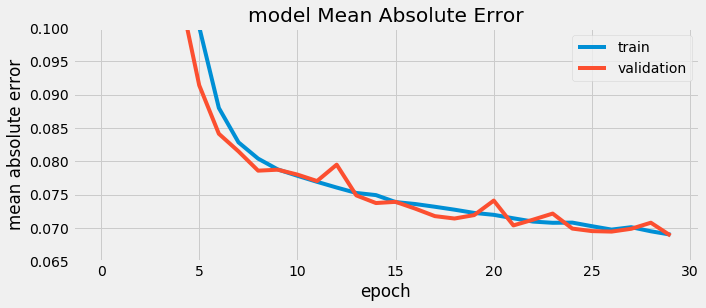

In [8]:
visualize_training_loss(history)

## Choosing the best n

In [13]:
n_range = np.linspace(-1, 2, 20)
y_pred = model.predict(x_train) / normalisation_constant
cost_function = trainig_for_best_n(train / normalisation_constant, y_pred, n_range=n_range)

We have earned -0.099 with gap parameter = -1.00
We have earned -0.116 with gap parameter = -0.84
We have earned -0.141 with gap parameter = -0.68
We have earned -0.168 with gap parameter = -0.53
We have earned -0.195 with gap parameter = -0.37
We have earned -0.224 with gap parameter = -0.21
We have earned -0.250 with gap parameter = -0.05
We have earned 0.999 with gap parameter = 0.11
We have earned 0.885 with gap parameter = 0.26
We have earned 0.722 with gap parameter = 0.42
We have earned 0.601 with gap parameter = 0.58
We have earned 0.470 with gap parameter = 0.74
We have earned 0.339 with gap parameter = 0.89
We have earned 0.237 with gap parameter = 1.05
We have earned 0.156 with gap parameter = 1.21
We have earned 0.091 with gap parameter = 1.37
We have earned 0.051 with gap parameter = 1.53
We have earned 0.029 with gap parameter = 1.68
We have earned 0.019 with gap parameter = 1.84
We have earned 0.012 with gap parameter = 2.00


## Let's plot revenue VS n

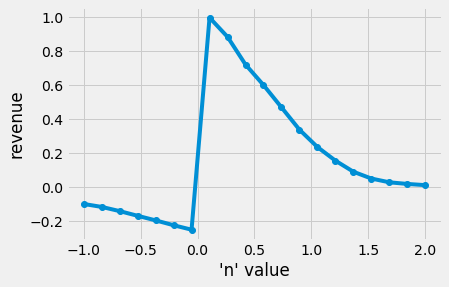

In [14]:
plt.plot(n_range, cost_function, marker='o');
plt.xlabel('\'n\' value');
plt.ylabel('revenue');

## Let's test fo $n=1$

In [15]:
y_pred = model.predict(x_test) / normalisation_constant
estimate_n(test / normalisation_constant, y_pred, n=0.11)

0.9775846385221598

## Conclustion for Method 4

The results are for test are almost the same as for train.
For full data set it should be:

$$ 0.97 \cdot 2 \approx 1.96 $$

While the upper bound is **2.57**

Current model achieves ~77% of the Upper Bound.

$$\frac{1.96}{2.57} \approx 76% $$

Maybe it is too good to be true.

### Comments,
##### Vizualization, of some random predictions

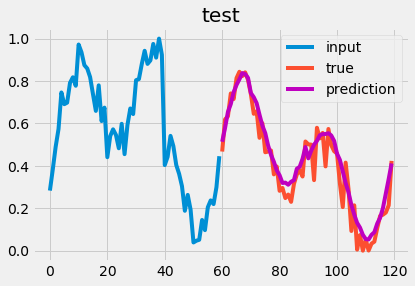

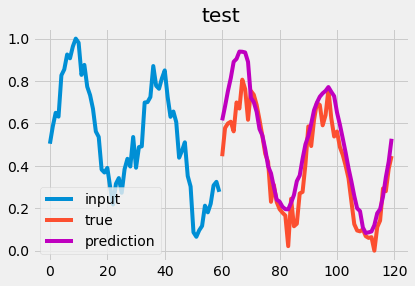

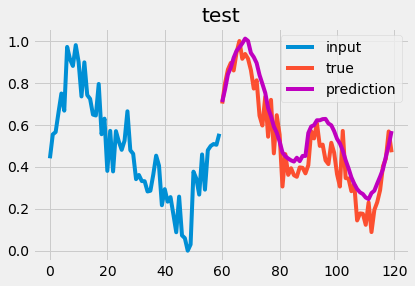

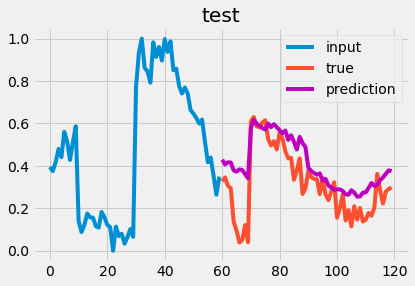

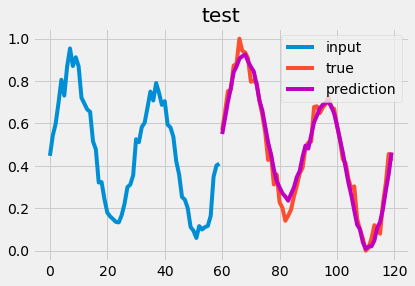

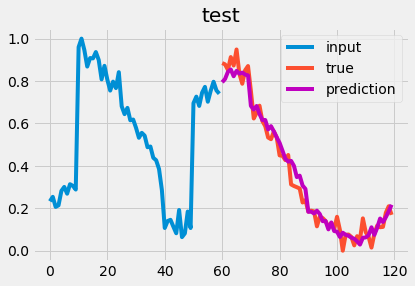

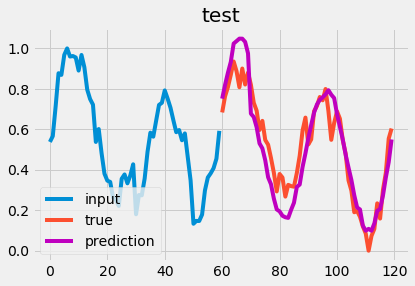

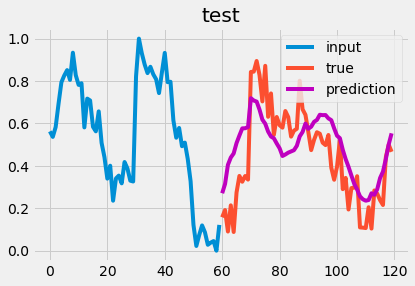

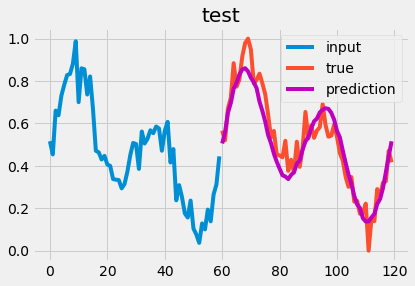

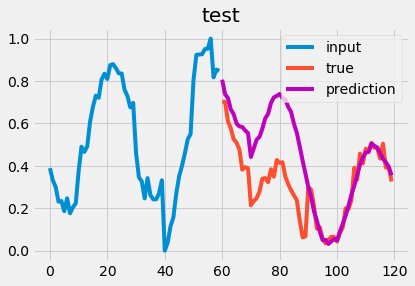

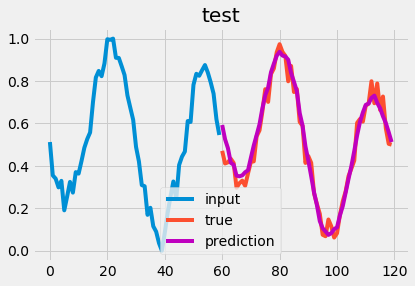

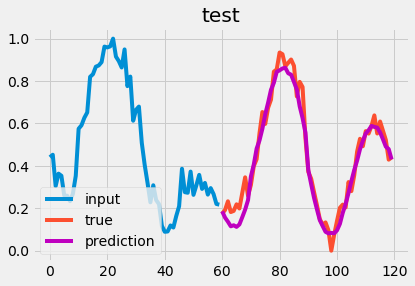

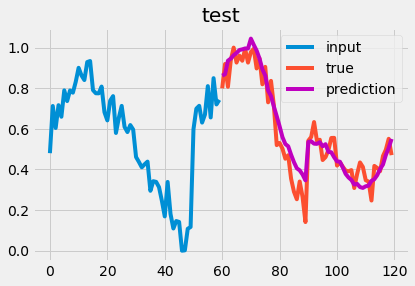

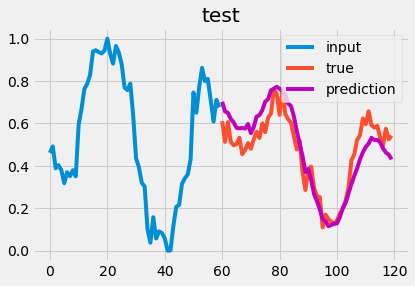

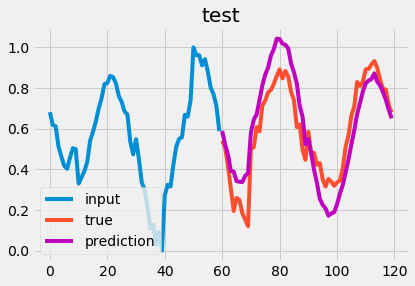

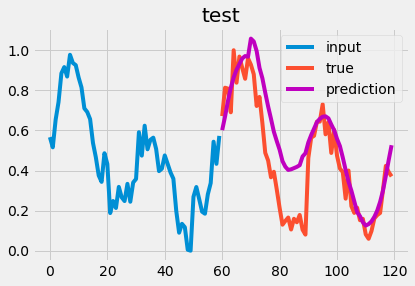

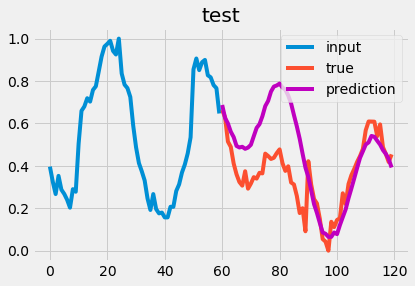

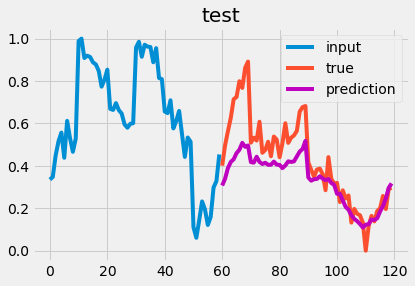

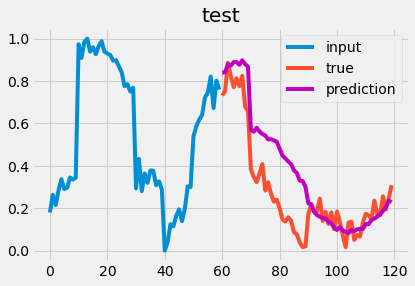

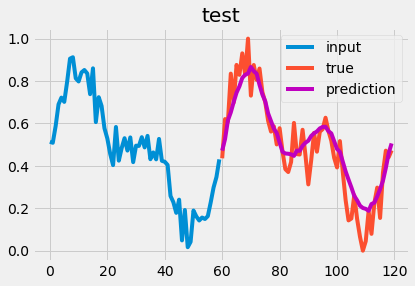

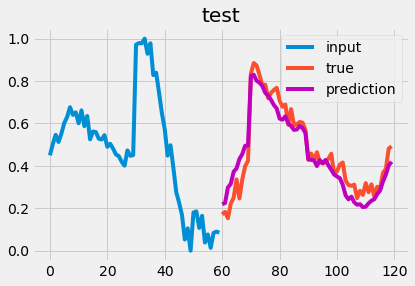

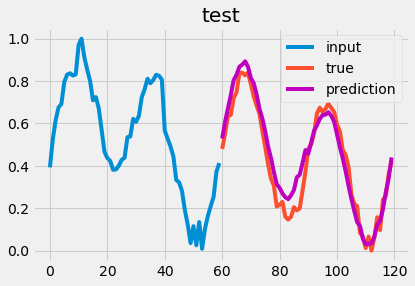

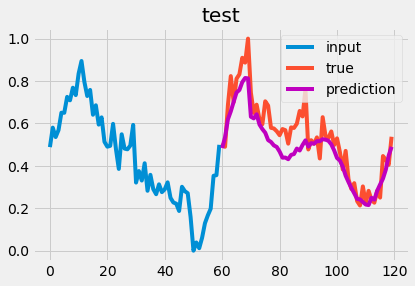

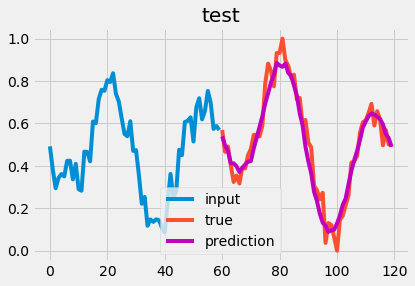

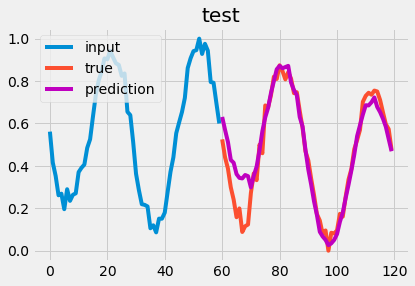

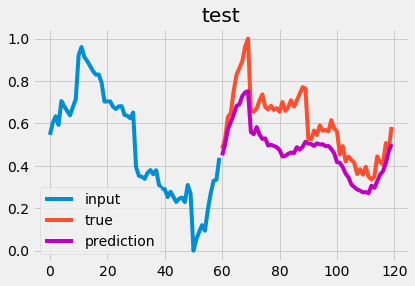

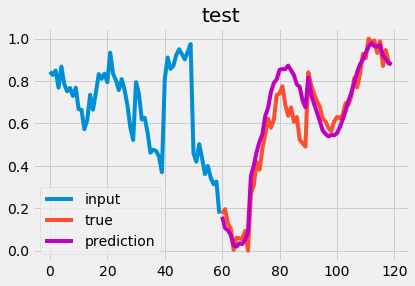

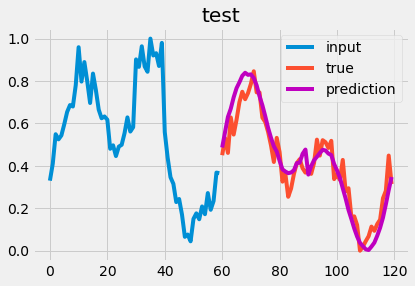

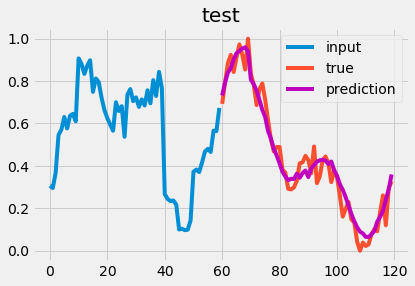

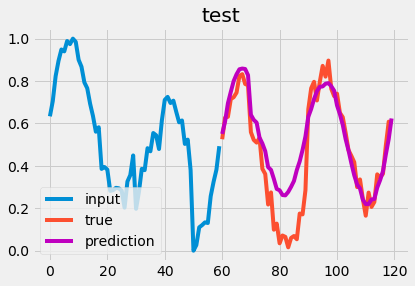

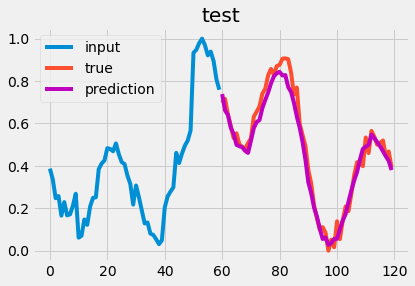

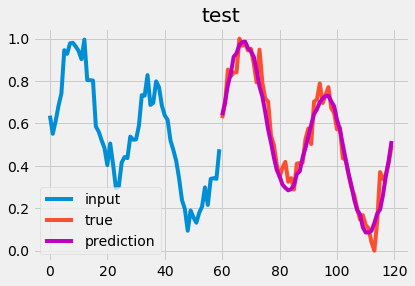

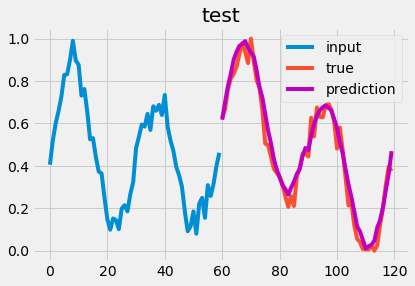

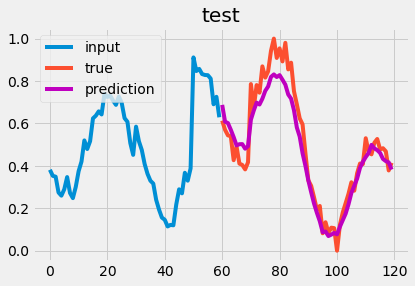

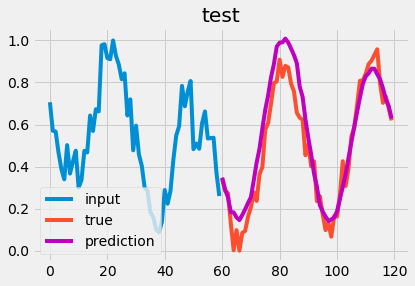

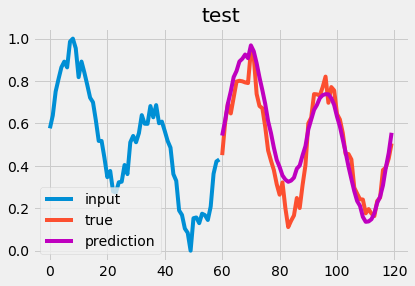

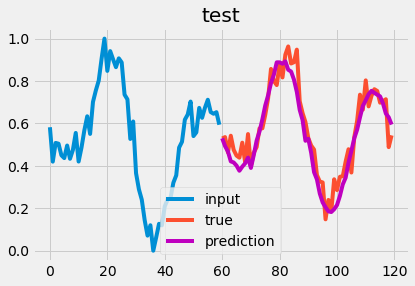

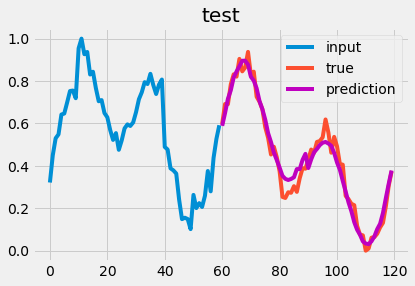

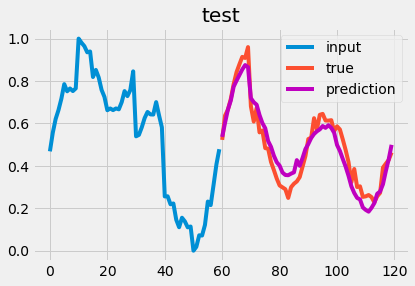

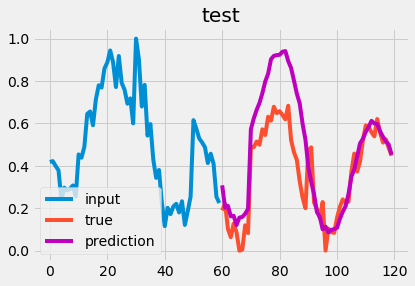

In [18]:
y_pred_test = model.predict(x_test)

random_indexes = range(data_numpy.shape[0]/2)
random.shuffle(random_indexes)

for i in random_indexes[:40]:
    plt.figure()
    plt.plot(range(60), x_test[i], label='input')
    plt.plot(range(60, 120), y_test[i], label='true')
    plt.plot(range(60, 120), y_pred_test[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()